In [21]:
import torch
from torch import nn
from lib.mnist_aug import caption_rules
from lib.mnist_aug.mnist_augmenter import DataManager, MNISTAug

In [22]:
aug = MNISTAug()
aug.min_objects = 1
aug.max_objects = 1

In [23]:
dm = DataManager()
dm.load()

In [24]:
x_train, y_train = aug.get_augmented(dm.x_train, dm.y_train, 2000, get_positional_labels=True)
x_test, y_test = aug.get_augmented(dm.x_test, dm.y_test, 10, get_positional_labels=True)

/Users/akhildevarashetti/code/ml_gallery/ml_py/venv/lib/python3.8/site-packages/skimage/transform/_warps.py:115: RuntimeWarning: divide by zero encountered in true_divide
  factors = (np.asarray(input_shape, dtype=float) /


cannot convert float infinity to integer
cannot convert float infinity to integer
cannot convert float infinity to integer
cannot convert float infinity to integer
cannot convert float infinity to integer


In [25]:
x_train = torch.FloatTensor(x_train.reshape((-1, 1, 112, 112)))
x_test = torch.FloatTensor(x_test.reshape((-1, 1, 112, 112)))
x_train.shape

torch.Size([2000, 1, 112, 112])

left


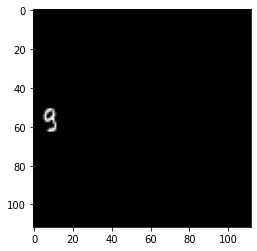

In [26]:
DataManager.plot_num(x_train[2].reshape((112, 112,)))
print(caption_rules.index_to_pos[y_train[2][0]['position']])

In [27]:
class PositionalEncoder2D(nn.Module):
    def __init__(self, c: int, h: int, w: int):
        super().__init__()
        self.w = (torch.rand((1, c, h, w)) - 0.5).requires_grad_()

    def forward(self, x):
        batch_size = x.shape[0]
        encoded = self.w.expand((batch_size, -1, -1, -1))
        return torch.cat((x, encoded), 1)

In [28]:
class PositionalClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 8, 3),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(8, 16, 3),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 16, 3),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, 3),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.pos_enc = PositionalEncoder2D(1, 5, 5)
        self.positional_compression = nn.Sequential(
            nn.Conv2d(32 + 1, 32, 3),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(nn.Linear(32, 10), nn.Softmax())
        self.position_classifier = nn.Sequential(nn.Linear(32, 9), nn.Softmax())

    def forward(self, x):
        features = self.features(x)
        positional_features = self.pos_enc(features)
        compressed = self.positional_compression(positional_features)
        flattened = torch.flatten(compressed, 1)
        cls = self.classifier(flattened)
        pos = self.position_classifier(flattened)
        return cls, pos

In [29]:
model = PositionalClassifier()
optimizer = torch.optim.Adam(model.parameters())
position_loss = torch.nn.CrossEntropyLoss()

In [33]:
epochs = 55
batch_size = 100

for epoch in range(epochs):

    losses = 0
    for i in range(0, len(x_train), batch_size):
        start_index = i
        end_index = i+batch_size

        x_batch = x_train[start_index:end_index]
        y_batch = y_train[start_index:end_index]
        y_pos = torch.tensor([y[0]['position'] for y in y_batch])
        y_cls = torch.tensor([y[0]['class'] for y in y_batch])

        optimizer.zero_grad()

        cls, pos = model(x_batch)

        loss_pos = position_loss(pos, y_pos)
        loss_cls = position_loss(cls, y_cls)

        loss = 0 * loss_cls + 1 * loss_pos

        loss.backward()
        optimizer.step()

        losses += float(loss)

    print(f'{epoch=}, loss={float(losses)}')

epoch=0, loss=31.37429428100586
epoch=1, loss=31.357876658439636
epoch=2, loss=31.000056266784668
epoch=3, loss=31.348206400871277
epoch=4, loss=31.53054678440094
epoch=5, loss=31.187605261802673
epoch=6, loss=31.174405336380005
epoch=7, loss=31.247859120368958
epoch=8, loss=31.691949725151062
epoch=9, loss=31.814229249954224
epoch=10, loss=31.393122792243958
epoch=11, loss=30.838671803474426
epoch=12, loss=30.776984214782715
epoch=13, loss=31.044670820236206
epoch=14, loss=31.51066565513611
epoch=15, loss=31.104241132736206
epoch=16, loss=31.169678807258606
epoch=17, loss=30.953701496124268
epoch=18, loss=31.251996636390686
epoch=19, loss=31.606220722198486
epoch=20, loss=31.08660650253296
epoch=21, loss=31.882612228393555
epoch=22, loss=31.24614691734314
epoch=23, loss=30.87450110912323
epoch=24, loss=31.185730576515198
epoch=25, loss=31.24519145488739
epoch=26, loss=31.1723290681839
epoch=27, loss=31.46374785900116
epoch=28, loss=32.01816737651825
epoch=29, loss=31.12279522418976
ep

center center
7 1
---
right right
0 1
---
top top
6 0
---
top-left top-left
6 2
---
top top-right
3 7
---
bottom-right bottom-right
0 9
---
right right
0 4
---
bottom-right bottom-right
0 8
---
top top
6 2
---
right right
0 8
---


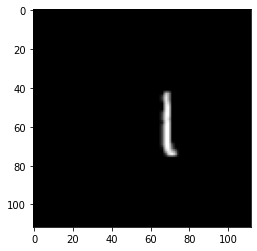

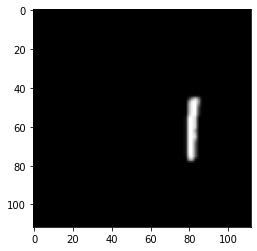

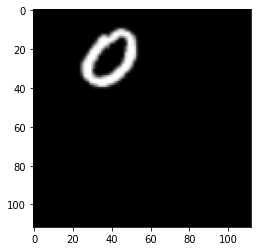

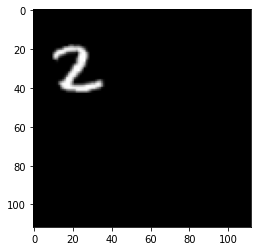

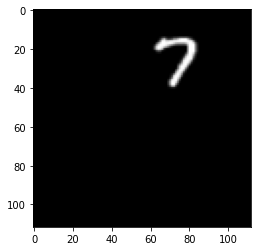

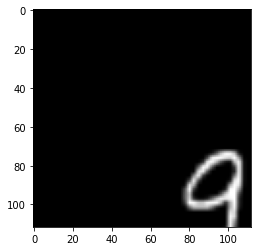

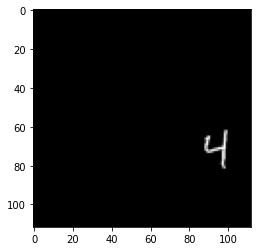

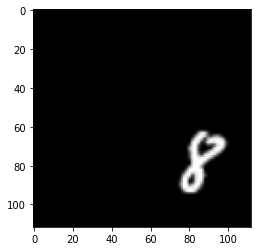

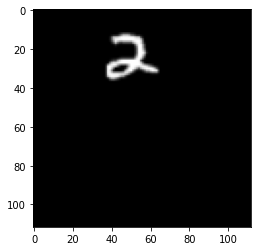

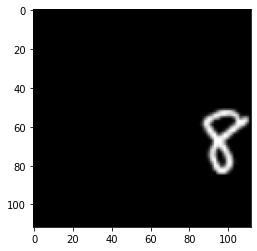

In [34]:
cls, pos = model(x_test)
_, pos = pos.max(1)
_, cls = cls.max(1)

y_test_pos = [y[0]['position'] for y in y_test]
y_test_cls = [y[0]['class'] for y in y_test]

for i in range(len(pos)):
    print(caption_rules.index_to_pos[int(pos[i])], caption_rules.index_to_pos[y_test_pos[i]])
    print(int(cls[i]), y_test_cls[i])
    print('---')
    DataManager.plot_num(x_test[i].reshape(112, 112))

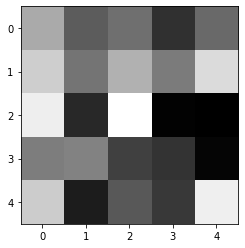

In [35]:
pos_enc = model.pos_enc.w

c1 = pos_enc[0][0].detach().numpy()

DataManager.plot_num(c1)

